In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import re
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure

In [ ]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
data = pd.read_csv('/content/task_3_event_prediction.tsv', sep = '\t')
print(len(data))

115668


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
counts = data.groupby(['EVENT_DATE']).size()
data = data[data['EVENT_DATE'].notna()]
data = data.reset_index(drop=True)

In [ ]:
newdata = data.drop_duplicates(subset=['EVENT_DATE'])
newdata['unrests'] = 0
newdata = newdata.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(newdata)):  
    newdata['unrests'][i] = counts[newdata['EVENT_DATE'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
newdata = pd.concat([newdata['EVENT_DATE'], newdata['unrests']], axis=1)

In [ ]:
newdata

,EVENT_DATE,unrests
0,01-January-2018,30
1,02-January-2018,55
2,03-January-2018,80
3,04-January-2018,34
4,05-January-2018,38
...,...,...
1478,18-January-2022,67
1479,19-January-2022,55
1480,20-January-2022,59
1481,21-January-2022,44


In [ ]:
newdata['unrests'] = newdata['unrests'].apply(lambda x: float(x))
series = newdata['unrests']
seq = series.copy()
print(series[:5])

0    30.0
1    55.0
2    80.0
3    34.0
4    38.0
Name: unrests, dtype: float64


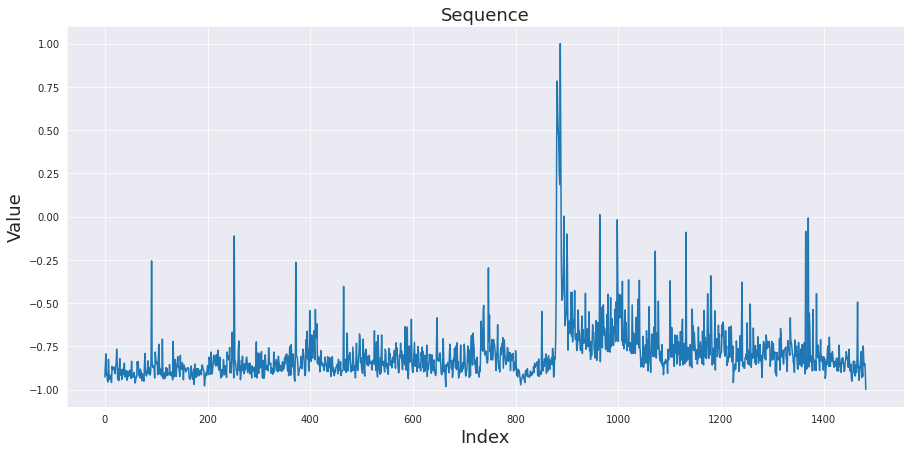

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Sequence", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(X)
plt.show()

In [ ]:
x_train = seq[:1000].values.reshape(-1,1)
y = seq[1000:].values.reshape(-1,1)

In [ ]:
x_train[:10]

array([[30.],
       [55.],
       [80.],
       [34.],
       [38.],
       [22.],
       [19.],
       [68.],
       [39.],
       [25.]])

In [ ]:
input_seq_len = 5
output_seq_len = 1
n_in_features = 1
n_out_features = 1
batch_size = 10

In [ ]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in range(total_start_points)]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range(total_start_points)]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [ ]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))

    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [ ]:
def run_model(model,batches,epochs,batch_size):

    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [ ]:
model_1 = create_model(layers=[10],bidirectional=False)

In [ ]:
total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model_1,batches=1, epochs=500, batch_size=batch_size)
end_time = time.time()

In [ ]:
run_time = (end_time - start_time)/60
run_time

9.94059853553772

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

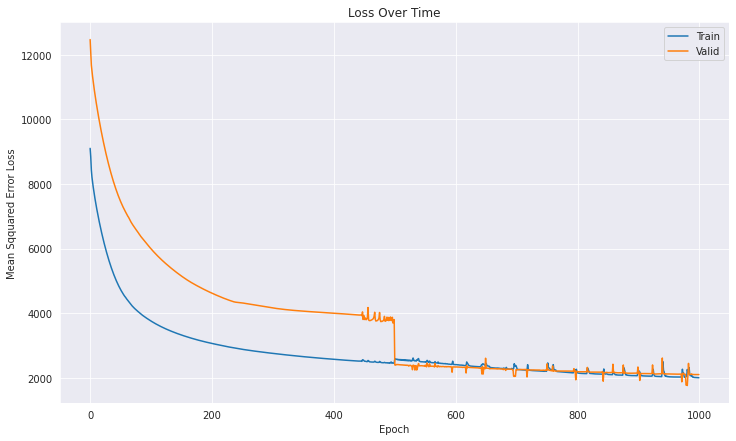

In [ ]:
plot_loss(total_loss,total_val_loss)

In [ ]:
input_seq = y[:10].reshape((1,10,1))
decoder_input_test = np.zeros((1,output_seq_len,1))
pred = model_1.predict([input_seq_test[0].reshape((1,10,1)),decoder_input_test])

In [ ]:
predictions = []
input_seq_test, output_seq_test = generate_train_sequences(y)
for i in range(len(y) - input_seq_len - output_seq_len):
    decoder_input_test = np.zeros((1,output_seq_len,1))
    input_seq = input_seq_test[i].reshape((1,10,1))
    pred = model_1.predict([input_seq,decoder_input_test])
    predictions.append(pred.item())

In [ ]:
len(predictions)

472

In [ ]:
Actual = []
for i in output_seq_test:
    Actual.append(i.item())

In [ ]:
len(Actual)

472

In [ ]:
if len(predictions) == len(Actual):
    print("All Good")

    print("R-Squared Value :", r2_score(Actual, predictions))
    

All Good
R-Squared Value : -0.2772653728064156


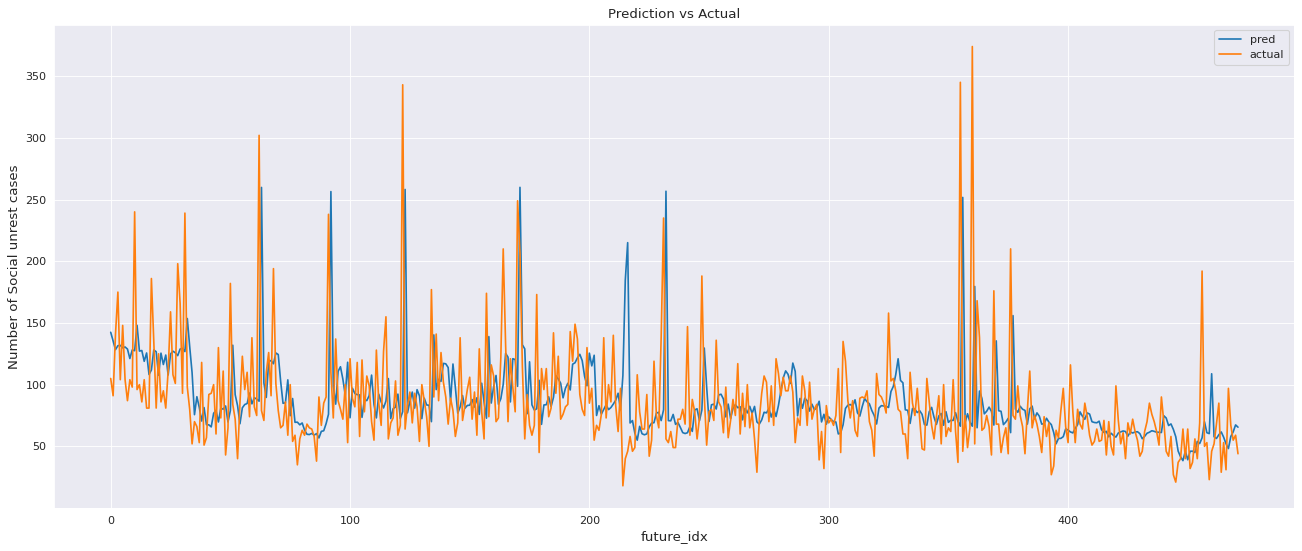

In [ ]:
figure(figsize=(20, 8), dpi=80)
plt.plot(predictions, label = "pred")
plt.plot(Actual, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('uni_dir1.png')
